# $J$-factors Maps

Making bidimensional $J$-factors maps.

## Description

By convention, we'll adopt the following definition of $J$-factors for annihilation:

$$ \frac{dJ_{\mathrm{a}}}{d\Omega} =  \int_{\mathrm{los}}\frac{ds}{r_{\odot}{}} \left ( \frac{\rho(r(s, \theta))}{\rho_{\odot}}\right)^2 $$
 
and for decayment:

$$ \frac{dJ_{\mathrm{d}}}{d\Omega} =  \int_{\mathrm{los}}\frac{ds}{r_{\odot}{}} \left ( \frac{\rho(r(s, \theta))}{\rho_{\odot}}\right)$$

As Cirelli defined, the flux, with spatial dependence included is:

$$\frac{d \Phi_\gamma}{d\Omega\,dE} = \frac{r_\odot}{4\pi} \frac{\rho_\odot}{M_{\rm DM}} \frac{dJ}{d\Omega}
\sum _f \Gamma_f  \frac{dN_\gamma^f}{dE}$$

But the way most articles on DM define the $J$-factor is by eliminating the spatial dependence with a integration on $d\Omega$. This way, the spectra is straighforwardly obtained:

$$\frac{d \Phi_\gamma}{dE} = \frac{1}{2}\frac{r_\odot}{4\pi} \left(\frac{\rho_\odot}{M_{\rm DM}}\right)^2 J
\sum _f\langle \sigma v\rangle_f \frac{dN_\gamma^f}{dE}  ,\qquad
$$

Now, what do we mean by a map of $J$-factors? We mean the $J$-factor:

$$ J =  \int_{\Delta \Omega} d\Omega \int_{\mathrm{los}}\frac{ds}{r_{\odot}{}} \left ( \frac{\rho(r(s, \theta))}{\rho_{\odot}}\right)^2 $$

calculated on a grid of galactic polar coordinates $(\ell, b)$ where $\theta = \theta(\ell, b) = \arccos{\left[\cos(\ell) \cos(b)\right]}$.

That is, for each grid position, there will be a fixed $\theta$ and the aperture ($\Delta \Omega$) integral will be calculated on the $\delta \ell \times \delta b$ regions of the grid:

$$\Delta \Omega \doteq \int_{\Delta \Omega} d\Omega = \int_{b_i-\frac{\delta b}{2}}^{b_i+\frac{\delta b}{2}} \int_{\ell_i-\frac{\delta \ell}{2}}^{\ell_i+\frac{\delta \ell}{2}} db\, d\ell\, \cos b$$

where $(\ell_i, b_i)$ is the grid center coordinate. This calculation can be done explicitly:

$$ \Delta \Omega = \left[\sin\left(b_i+\frac{\delta b}{2}\right)-\sin\left(b_i-\frac{\delta b}{2}\right)\right] \delta \ell $$

Our final result will then be:

$$ J = \frac{dJ}{d\Omega} \times \Delta \Omega$$

for each grid position.

## Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
import astropy.wcs as wcs
from astropy.io import fits

In [3]:
from datetime import datetime

In [4]:
from dm.profiles import MassProfileNFW, MassProfileEinasto, MassProfileIsothermal, MassProfileBurkert, MassProfileMoore

In [5]:
plt.style.use('astroph')

### Utils

Helper functions to plot, generate FITS and get WCS.

#### Plot profiles 

In [6]:
def profile_plot(j_factors, l, b, wcs, grid=False, cmap=plt.cm.plasma, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)
    im = ax.imshow(j_factors, origin='lower', cmap=cmap, **kwargs)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$\dfrac{d\,J(\theta)}{d\Omega} \times \Delta \Omega_{\mathrm{bin}}$",  fontsize=14,  labelpad=10)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$b$ ($\degree$)')
    ax.set_xlabel(r'$\ell$ ($\degree$)')
    if grid:
        for x in range(l.size):
            ax.axvline(x, color='grey', lw=0.3, alpha=0.8)
        for y in range(b.size):
            ax.axhline(y, color='grey', lw=0.3, alpha=0.8)

#### $\theta$ Grid Generator

In [7]:
def generate_grid(l, b):
    L, B = np.meshgrid(l, b)
    thetas = np.arccos(np.cos(L)*np.cos(B))
    return thetas

#### FITS Generator

In [8]:
def generate_fits(data, wcs, filename, factor_type='annihilation'):
    hdu = fits.PrimaryHDU(data, header=wcs.to_header())
    header = hdu.header
    header.set('MAPTYPE', factor_type.upper(), 'J-Factor map type: annihilation or decay')
    header.set('HISTORY', 'Last update in %s'%str(datetime.today().date()))
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

#### WCS Generator

In [9]:
def generate_wcs(l, b, delta_l, delta_b):
    """Specify WCS for the map. 
    
    The reference pixel is the first one, indexed by 1 
    in FORTRAN and FITS convention. Default for us will
    be numpy convention that the first pixel is 0.
    """
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ['GLON-CAR', 'GLAT-CAR']
    w.wcs.crval = np.array([l[0], b[0]])
    w.wcs.crpix = np.array([1, 1])
    w.wcs.cdelt = np.array([delta_l, delta_b], dtype=np.float64)
    w.wcs.cunit = ['deg', 'deg']
    return w

### Profiles

In [10]:
nfw = MassProfileNFW()
einasto = MassProfileEinasto()
isothermal = MassProfileIsothermal()
burkert = MassProfileBurkert()
moore = MassProfileMoore()

### Maps

| Latitude ($b$) or aperture ($\theta$) | Longitude ($\ell$)|
|:----: |:---:|
| $|b| \leq 1°$| $|\ell| \leq 1°$ |


**Threshold**

There is a integration threshold on $\theta_T =$ ```4e-3°```, *i.e.* $\theta < \theta_T$ will raise a integration warning.

In [11]:
delta_b1 = delta_l1 = 0.05

In [12]:
b_min1, b_max1, l_min1, l_max1 = -5.0, 5.0, -5.0, 5.0

In [13]:
b1 = np.arange(b_min1, b_max1, delta_b1) + delta_b1/2.0
l1 = np.arange(l_min1, l_max1, delta_l1) + delta_l1/2.0

In [14]:
b1_rad = b1*np.pi/180.0
l1_rad = l1*np.pi/180.0

In [15]:
delta_b1_rad = delta_b1*np.pi/180.0
delta_l1_rad = delta_l1*np.pi/180.0

In [16]:
L1, B1 = np.meshgrid(l1_rad, b1_rad)

In [17]:
thetas = generate_grid(l1_rad, b1_rad)

In [18]:
apertures = nfw.apertures_map(L1, B1, delta_l1_rad, delta_b1_rad)

In [19]:
nfw_annih = nfw.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3)
nfw_decay = nfw.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3, factor_type='decay')

In [20]:
einasto_annih = einasto.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3) 
einasto_decay = einasto.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3, factor_type='decay') 

In [21]:
isothermal_annih = isothermal.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3)
isothermal_decay = isothermal.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3, factor_type='decay')

In [22]:
burkert_annih = burkert.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3)
burkert_decay = burkert.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3, factor_type='decay')

In [23]:
moore_annih = moore.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3)
moore_decay = moore.j_factor_map(L1, B1, delta_l1_rad, delta_b1_rad, epsrel=1e-3, factor_type='decay')

#### Results

In [20]:
w = wcs.WCS(naxis=2)

In [21]:
wcs1 = generate_wcs(l1, b1, delta_l1, delta_b1)

* Aperture Map

In [19]:
def save_aperture_map(apertures, filename='maps/apertures.fits'):
    hdu_aperture = fits.PrimaryHDU(apertures)
    header = hdu_aperture.header
    header.set('MAPTYPE', 'APERTURE')
    header.set('HISTORY', 'Last update in %s'%str(datetime.today().date()))
    hdul = fits.HDUList([hdu_aperture])
    hdul.writeto(filename, overwrite=True)

In [20]:
save_aperture_map(apertures)

* $\theta$ map

In [24]:
def save_theta_map(apertures, filename='maps/thetas.fits'):
    hdu_aperture = fits.PrimaryHDU(apertures)
    header = hdu_aperture.header
    header.set('MAPTYPE', 'THETAS')
    header.set('HISTORY', 'Last update in %s'%str(datetime.today().date()))
    hdul = fits.HDUList([hdu_aperture])
    hdul.writeto(filename, overwrite=True)

In [25]:
save_theta_map(thetas)

* NFW

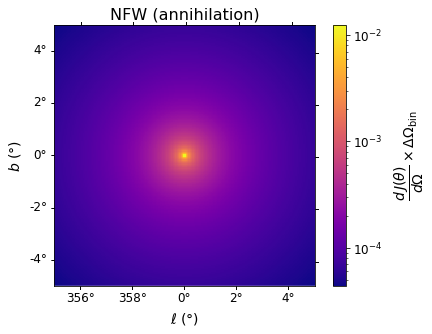

In [30]:
profile_plot(nfw_annih, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=nfw_annih.min(), vmax=nfw_annih.max()))
plt.title("NFW (annihilation)")
plt.show()

In [33]:
import astropy.units as u

In [34]:
r_sun = 8.33*u.kpc

In [36]:
r_sun.to(u.cm)

<Quantity 2.57036943e+22 cm>

In [45]:
0.5* (1/(4*np.pi)) * np.sum(nfw_annih*apertures)*(0.3*u.GeV/u.cm**3)**2 * (r_sun.to(u.cm))

<Quantity 3.6996583e+14 GeV2 / cm5>

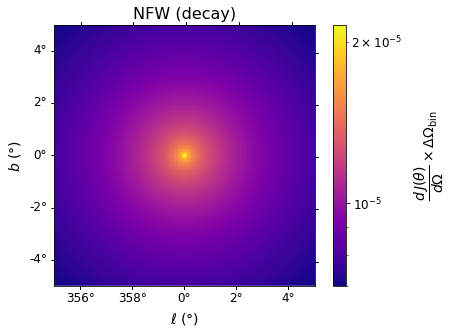

In [31]:
profile_plot(nfw_decay, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=nfw_decay.min(), vmax=nfw_decay.max()))
plt.title("NFW (decay)")
plt.show()

In [28]:
generate_fits(nfw_annih, wcs1, 'maps/nfw_annih.fits')

In [29]:
generate_fits(nfw_decay, wcs1, 'maps/nfw_decay.fits', factor_type='decay')

* Einasto

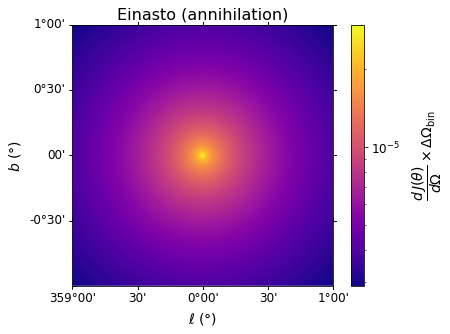

In [34]:
profile_plot(einasto_annih, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=einasto_annih.min(), vmax=einasto_annih.max()))
plt.title("Einasto (annihilation)")
plt.show()

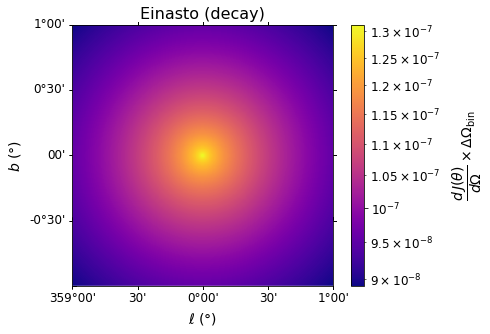

In [35]:
profile_plot(einasto_decay, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=einasto_decay.min(), vmax=einasto_decay.max()))
plt.title("Einasto (decay)")
plt.show()

In [36]:
generate_fits(einasto_annih, wcs1, 'maps/einasto_annih.fits')

In [37]:
generate_fits(einasto_decay, wcs1, 'maps/einasto_decay.fits', factor_type='decay')

* Isothermal

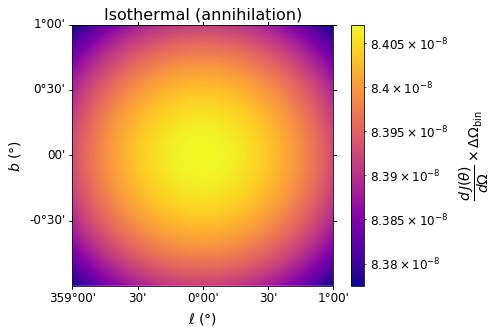

In [38]:
profile_plot(isothermal_annih, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=isothermal_annih.min(), vmax=isothermal_annih.max()))
plt.title("Isothermal (annihilation)")
plt.show()

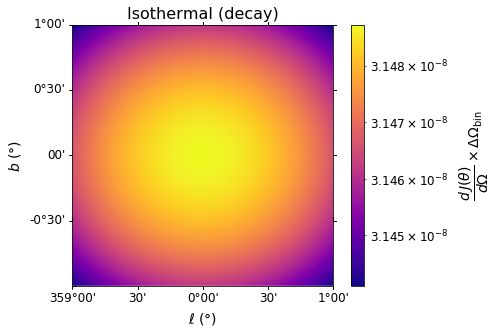

In [39]:
profile_plot(isothermal_decay, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=isothermal_decay.min(), vmax=isothermal_decay.max()))
plt.title("Isothermal (decay)")
plt.show()

In [40]:
generate_fits(isothermal_annih, wcs1, 'maps/isothermal_annih.fits')

In [41]:
generate_fits(isothermal_decay, wcs1, 'maps/isothermal_decay.fits', factor_type='decay')

* Burkert 

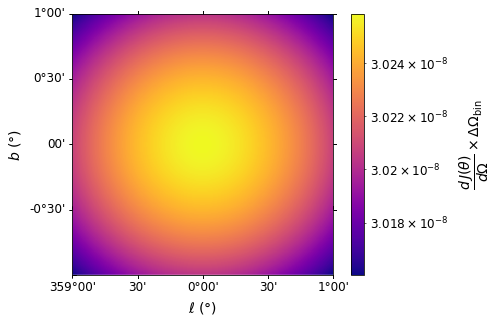

In [42]:
profile_plot(burkert_annih, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=burkert_annih.min(), vmax=burkert_annih.max()))

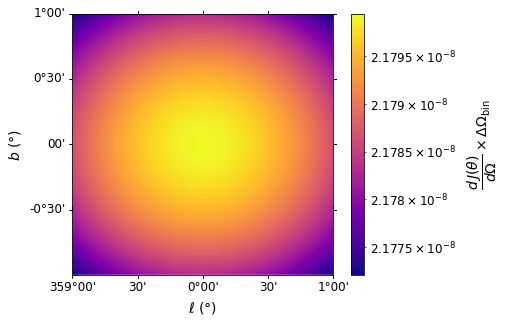

In [43]:
profile_plot(burkert_decay, l1, b1, wcs1, cmap=plt.cm.plasma,  norm=colors.LogNorm(vmin=burkert_decay.min(), vmax=burkert_decay.max()))

In [44]:
generate_fits(burkert_annih, wcs1, 'maps/burkert_annih.fits')

In [45]:
generate_fits(burkert_decay, wcs1, 'maps/burkert_decay.fits', factor_type='decay')

* Moore

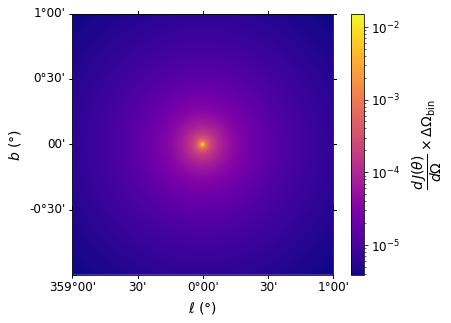

In [46]:
profile_plot(moore_annih, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=moore_annih.min(), vmax=moore_annih.max()))

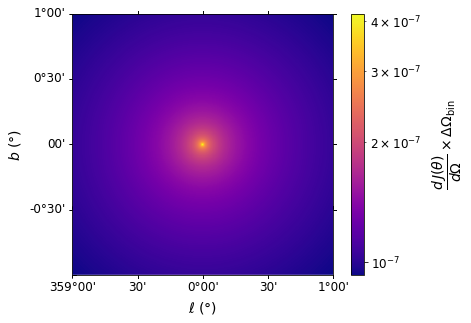

In [47]:
profile_plot(moore_decay, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=moore_decay.min(), vmax=moore_decay.max()))

In [48]:
generate_fits(moore_annih, wcs1, 'maps/moore_annih.fits')

In [49]:
generate_fits(moore_decay, wcs1, 'maps/moore_decay.fits', factor_type='decay')